<a href="https://colab.research.google.com/github/Irenee123/HiddenMarkov_Model/blob/main/notebooks/hmm_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Irenee123/HiddenMarkov_Model.git

Cloning into 'HiddenMarkov_Model'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (285/285), done.
remote: Compressing objects: 100% (278/278), done.
remote: Total 285 (delta 118), reused 15 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (285/285), 4.03 MiB | 6.55 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [3]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 4.9 MB/s eta 0:00:00


In [4]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from numpy.fft import fft, fftfreq

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

from hmmlearn.hmm import GaussianHMM

# Set a random seed for reproducibility
np.random.seed(42)

In [5]:
# --- Configuration ---

# 1. Path to your main data folder
DATA_DIR = "/content/HiddenMarkov_Model/Dataz/"

# 2. Define your activities (must match folder prefixes)
ACTIVITIES = ['Standing', 'Walking', 'Jumping', 'Still']
N_STATES = len(ACTIVITIES)

# 3. Sensor Logger sampling rate
SAMPLING_RATE_HZ = 100

# 4. Windowing parameters
# Justification: 1-second window is long enough to capture a gait cycle
# or jump, but short enough for fast transitions.
WINDOW_SIZE_SEC = 1.0
WINDOW_SAMPLES = int(SAMPLING_RATE_HZ * WINDOW_SIZE_SEC)

# 50% overlap (as recommended in the rubric walkthrough)
STEP_SIZE_SEC = 0.5
STEP_SAMPLES = int(SAMPLING_RATE_HZ * STEP_SIZE_SEC)

# 5. Define your feature names (for plotting later)
# This MUST match the order in `extract_features`
FEATURE_NAMES = [
    'acc_x_mean', 'acc_y_mean', 'acc_z_mean',
    'acc_x_var', 'acc_y_var', 'acc_z_var',
    'acc_sma',
    'gyro_x_mean', 'gyro_y_mean', 'gyro_z_mean',
    'gyro_x_var', 'gyro_y_var', 'gyro_z_var',
    'acc_spectral_energy', 'gyro_spectral_energy'
]

In [6]:
def load_data_from_folder(folder_path):
    """
    Loads, merges, and cleans accelerometer and gyroscope data
    from a single Sensor Logger subfolder.
    """
    accel_path = os.path.join(folder_path, "Accelerometer.csv")
    gyro_path = os.path.join(folder_path, "Gyroscope.csv")

    # Load data
    df_accel = pd.read_csv(accel_path)
    df_gyro = pd.read_csv(gyro_path)

    # Rename columns for clarity before merging
    df_accel.rename(columns={'x': 'acc_x', 'y': 'acc_y', 'z': 'acc_z'}, inplace=True)
    df_gyro.rename(columns={'x': 'gyro_x', 'y': 'gyro_y', 'z': 'gyro_z'}, inplace=True)

    # Merge on time. We use an inner merge to ensure all
    # timestamps are valid for both sensors.
    df_merged = pd.merge(df_accel, df_gyro, on='time')

    # We only need the sensor columns for feature extraction
    sensor_columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

    return df_merged[sensor_columns]

In [7]:
def extract_features(window_df):
    """
    Extracts time and frequency domain features from a window
    of sensor data.
    """
    features = []

    # 1. Time-Domain Features
    # Mean and Variance for all 6 axes
    features.extend(window_df.mean().values)
    features.extend(window_df.var().values)

    # Signal Magnitude Area (SMA) for Accelerometer
    sma_acc = np.sum(np.abs(window_df['acc_x']) + np.abs(window_df['acc_y']) + np.abs(window_df['acc_z'])) / len(window_df)
    features.append(sma_acc)

    # 2. Frequency-Domain Features
    # Spectral Energy for Accelerometer (sum of all 3 axes)
    accel_mag = np.sqrt(window_df['acc_x']**2 + window_df['acc_y']**2 + window_df['acc_z']**2)
    fft_vals = np.abs(fft(accel_mag))
    spectral_energy_acc = np.sum(fft_vals**2) / len(window_df)
    features.append(spectral_energy_acc)

    # Spectral Energy for Gyroscope (sum of all 3 axes)
    gyro_mag = np.sqrt(window_df['gyro_x']**2 + window_df['gyro_y']**2 + window_df['gyro_z']**2)
    fft_vals = np.abs(fft(gyro_mag))
    spectral_energy_gyro = np.sum(fft_vals**2) / len(window_df)
    features.append(spectral_energy_gyro)

    # Note: Add more features here if you want (e.g., dominant frequency)

    return np.array(features)

In [8]:
def process_data(folder_paths):
    """
    Takes a list of data folders, processes each one, and returns
    the data in the (X, lengths) format required by hmmlearn,
    plus labels for evaluation.
    """
    all_features = []
    all_lengths = []
    all_window_labels = [] # Ground truth for each window

    for path in folder_paths:

        # Get the label (e.g., 'walking') from the folder name
        label = os.path.basename(path).split('_')[0]

        # Load the merged sensor data
        df = load_data_from_folder(path)

        features_for_this_file = []

        # Apply the sliding window
        for i in range(0, len(df) - WINDOW_SAMPLES, STEP_SAMPLES):
            window = df.iloc[i : i + WINDOW_SAMPLES]

            # Extract features from the window
            features = extract_features(window)
            features_for_this_file.append(features)
            all_window_labels.append(label)

        if features_for_this_file:
            all_features.append(np.array(features_for_this_file))
            all_lengths.append(len(features_for_this_file))

    # Concatenate all features from all files into one big array
    X = np.concatenate(all_features)

    # Create an array of the ground truth labels
    y_true = np.array(all_window_labels)

    return X, all_lengths, y_true

In [9]:
# Find all subfolders in the data directory
all_subfolders = [f.path for f in os.scandir(DATA_DIR) if f.is_dir()]

# Filter to only include folders for our defined activities
valid_folders = [f for f in all_subfolders if os.path.basename(f).split('_')[0] in ACTIVITIES]

print(f"Found {len(valid_folders)} total data folders.")

# Split the list of folders into training and testing sets
# We use an 80/20 split.
train_folders, test_folders = train_test_split(valid_folders, test_size=0.2, random_state=42)

print(f"Using {len(train_folders)} folders for Training.")
print(f"Using {len(test_folders)} folders for Testing.")

Found 9 total data folders.
Using 7 folders for Training.
Using 2 folders for Testing.


In [10]:
# Process Training Data
X_train, lengths_train, y_train_true = process_data(train_folders)
print(f"Training data shape (X_train): {X_train.shape}")
print(f"Number of training sequences: {len(lengths_train)}")

# Process Testing Data
X_test, lengths_test, y_test_true = process_data(test_folders)
print(f"Test data shape (X_test): {X_test.shape}")
print(f"Number of test sequences: {len(lengths_test)}")

Training data shape (X_train): (145, 15)
Number of training sequences: 7
Test data shape (X_test): (42, 15)
Number of test sequences: 2


In [11]:
# Justification (for your report):
# We use Z-score normalization (StandardScaler) because our features
# have vastly different scales (e.g., variance vs. spectral energy).
# Normalization ensures all features contribute equally to the model
# and helps the Gaussian HMM optimization converge.

scaler = StandardScaler()

# Fit ONLY on the training data
X_train_norm = scaler.fit_transform(X_train)

# Transform the test data using the *same* scaler
X_test_norm = scaler.transform(X_test)

print("Data successfully normalized.")

Data successfully normalized.


In [12]:
print("Training HMM (this may take a moment)...")

model = GaussianHMM(n_components=N_STATES,
                    covariance_type="diag",
                    n_iter=100,  # Max iterations
                    tol=1e-4,    # Convergence threshold
                    random_state=42)

# This is the Baum-Welch algorithm
model.fit(X_train_norm, lengths_train)

print("HMM trained successfully.")

Training HMM (this may take a moment)...
HMM trained successfully.


In [13]:
# 1. Predict states for the TRAINING data
train_hidden_states = model.predict(X_train_norm, lengths_train)

# 2. Find the most common hidden state for each true label
state_map = {}
for i, activity in enumerate(ACTIVITIES):
    # Find all windows where the true label was this activity
    mask = (y_train_true == activity)

    # Find the most frequent hidden state for those windows
    most_common_state = stats.mode(train_hidden_states[mask], keepdims=False).mode

    state_map[most_common_state] = activity

print("--- State Mapping ---")
print("HMM State -> Activity Label")
for state, label in state_map.items():
    print(f"State {state} -> {label}")

# Check for a bad mapping (e.g., two labels map to one state)
if len(state_map) < N_STATES:
    print("\n*** WARNING: Bad state mapping! ***")
    print("Not all states were mapped. Your model may be confused.")
    print("Try re-training or check your features.")

--- State Mapping ---
HMM State -> Activity Label
State 0 -> Walking
State 1 -> Jumping
State nan -> Still

*** WARNING: Bad state mapping! ***
Not all states were mapped. Your model may be confused.
Try re-training or check your features.


/tmp/ipython-input-3020684047.py:11: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  most_common_state = stats.mode(train_hidden_states[mask], keepdims=False).mode



--- Classification Report ---
              precision    recall  f1-score   support

    Standing       0.00      0.00      0.00         0
     Walking       1.00      0.52      0.69        21
     Jumping       0.68      1.00      0.81        21
       Still       0.00      0.00      0.00         0

    accuracy                           0.76        42
   macro avg       0.42      0.38      0.37        42
weighted avg       0.84      0.76      0.75        42


--- Confusion Matrix ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

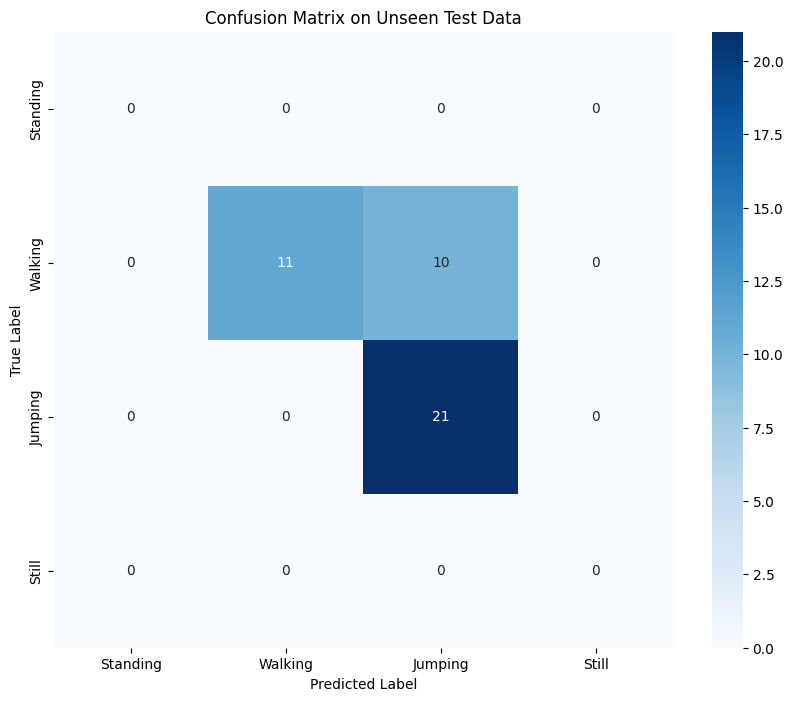

In [14]:
# 1. Predict hidden states for the TEST data (Viterbi algorithm)
test_hidden_states = model.predict(X_test_norm, lengths_test)

# 2. Convert integer states to activity labels using our map
y_pred = [state_map.get(state, "Unknown") for state in test_hidden_states]

# 3. Compare y_pred (model's predictions) to y_test_true (ground truth)
print("\n--- Classification Report ---")
print(classification_report(y_test_true, y_pred, labels=ACTIVITIES))


# 4. Generate and plot the Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_true, y_pred, labels=ACTIVITIES)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
plt.title('Confusion Matrix on Unseen Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

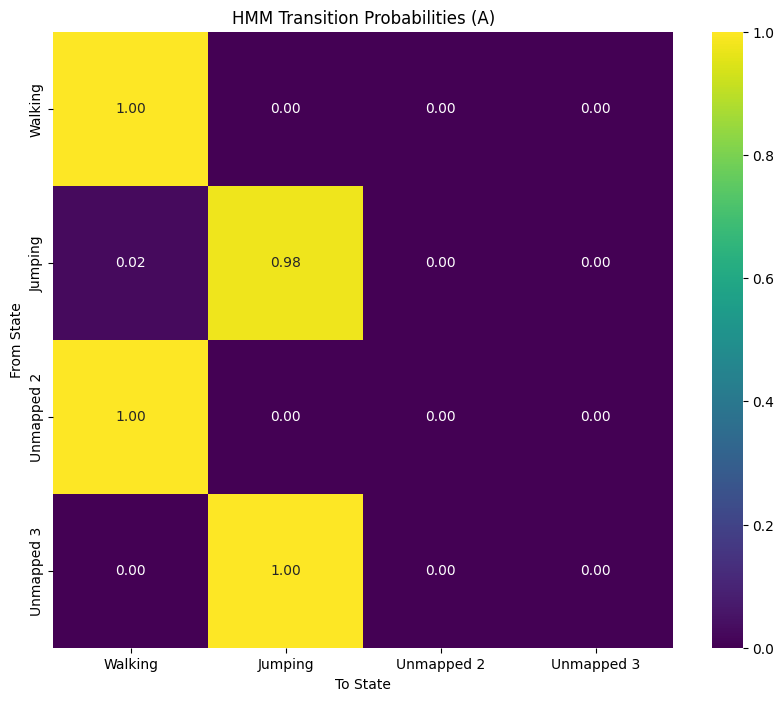

In [15]:
# 1. Get the transition matrix
trans_mat = model.transmat_

# 2. Get the mapped labels for the axes
mapped_labels = [state_map.get(i, f"Unmapped {i}") for i in range(N_STATES)]

# 3. Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(trans_mat, annot=True, fmt='.2f', cmap='viridis',
            xticklabels=mapped_labels, yticklabels=mapped_labels)
plt.title('HMM Transition Probabilities (A)')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()

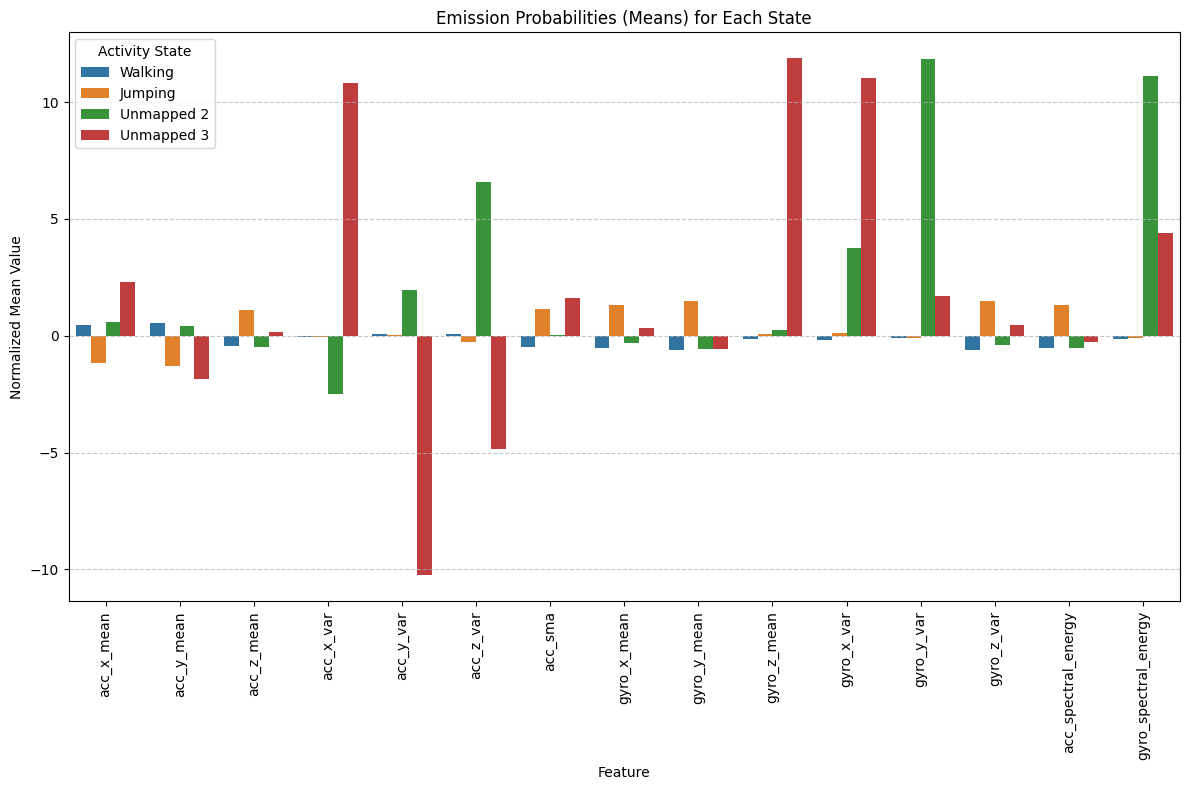

In [16]:
# 1. Get the emission means
emission_means = model.means_

# 2. Create a DataFrame for easy plotting
df_emissions = pd.DataFrame(emission_means, columns=FEATURE_NAMES)
df_emissions['State'] = [state_map.get(i, f"Unmapped {i}") for i in range(N_STATES)]

# 3. "Melt" the DataFrame into a long format for Seaborn
df_emissions_long = df_emissions.melt(id_vars='State',
                                      var_name='Feature',
                                      value_name='Normalized Mean Value')

# 4. Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=df_emissions_long, x='Feature', y='Normalized Mean Value', hue='State')
plt.title('Emission Probabilities (Means) for Each State')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Activity State')
plt.tight_layout()
plt.show()